In [3]:
import torch
import torch.nn as nn
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)


In [4]:
# z = wx + b, loss = (y-z)^2

In [5]:
# Layers are stored in a cascaded way 
model = nn.Sequential(
    nn.Linear(4, 16), 
    nn.ReLU(), 
    nn.Linear(16, 32), 
    nn.ReLU()
)

model 

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [6]:
# specify initial value distribution for weight for first layer
nn.init.xavier_uniform_(model[0].weight)
# l1 penatly for second layer weight matrix
l1_weight = 0.01
# l1 norm fo the second layer weights 
l1_penalty = l1_weight * model[2].weight.abs().sum()
# binary cross entropy loss 
loss_fn = nn.BCELoss()
# sgd
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [7]:
# XOR classification problem
# generate toy dataset of 200 training exampels with features x0, x1
# x0, x1 drawn from uniform dist. between [-1, 1)
# y = 0 if xo*x1 < 0 else 1
import matplotlib.pyplot as plt 
import numpy as np 
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))

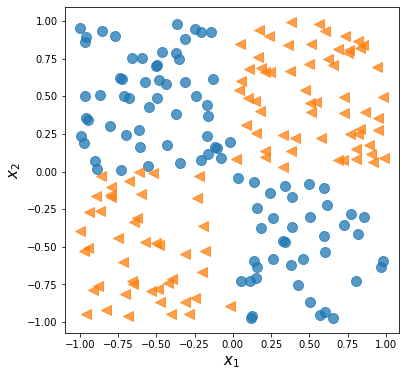

In [8]:
y = np.ones(len(x))
y[x[:,0] * x[:,1] < 0] = 0 
n_train = 100 
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)
fig = plt.figure(figsize=(6,6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [9]:
model = nn.Sequential(
    nn.Linear(2, 1), 
    nn.Sigmoid(),
)
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [10]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [11]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [27]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        # normalizing, since n_train = 100 and the batch_size=2 then 
        # have to divide by 100/2 = 50. 
        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

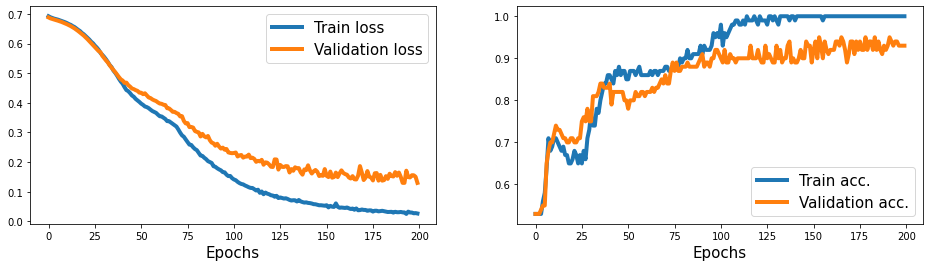

In [28]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4) 
plt.plot(history[3], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [26]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [33]:
# nn.module subclassing 
class MyModule(nn.Module): 
    def __init__(self): 
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x): 
        for f in self.module_list: 
            x = f(x)
        return x 

    def predict(self, x): 
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()


In [34]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Text(0.5, 0, 'Epochs')

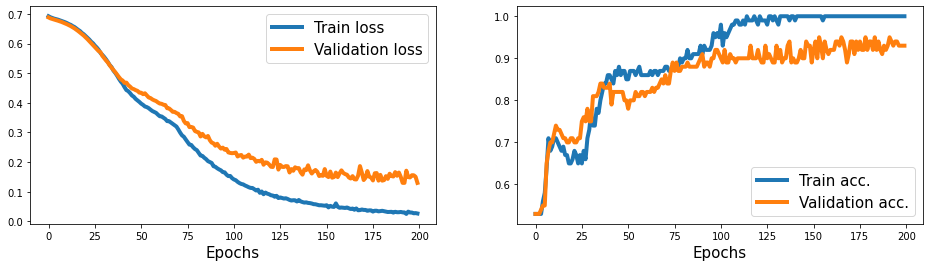

In [35]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4) 
plt.plot(history[3], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [42]:
# custom layers that computes w(x + є) + b, where є is a noise term
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training: 
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else: 
            x_new = x 
        return torch.add(torch.mm(x_new, self.w), self.b)

In [43]:
# test NoisyLinear 
torch.manual_seed(1)
noisy_layer = NoisyLinear(4, 2)
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=True))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[-0.0366,  0.0022]], grad_fn=<AddBackward0>)


In [45]:
# create a new model similar to old one 
class MyNoisyModule(nn.Module):
    def __init__(self): 
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x 

    def predict(self, x): 
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

In [46]:
torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [47]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
torch.manual_seed(1)
loss_hist_train = [0] * num_epochs 
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs): 
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:,0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()
    
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

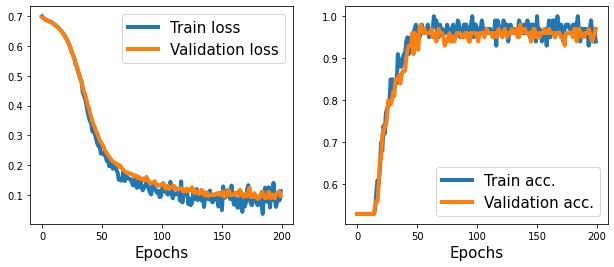

In [49]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_06.png', dpi=300)
plt.show()